### コーパスの下準備

# Chapter02 自然言語と単語の分散表現

- そもそも自然言語処理(NLP)とは?
  - 人間が普段使う言葉をコンピュータに理解させる為の技術
  - 自然言語は同じ意味の文章でも多様な言い回し, 文章に対する曖昧さが存在するといった柔軟性がある
    - こうした柔軟性のある言語を機会に理解させるのは難しい → これを解決するのが目標
    - ex) 機械翻訳, 検索エンジン, IME, etc...

- 本章のテーマ: 単語の意味をコンピュータに理解させる
  - 言葉は文字によって構成されるが、言葉の意味は単語によって構成される(i.e. 意味を表す「最小単位」)
  - 本章と次章で以下の3つの手法による単語の意味を捉えた表現方法について考える
    - シソーラスによる手法(ただしこのノートでは省略する)
    - カウントベースの手法
    - 推論ベースの手法(次章)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

In [34]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    # 単語から単語IDへの辞書
    word_to_id = {}
    
    # 単語IDから単語への辞書
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    # corpus: 単語IDのリスト
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [35]:
# 処理の確認
test_txt = 'You say goodbye and I say hello.'
test_corpus, test_word_to_id, test_id_to_word = preprocess(test_txt)
print(test_corpus)
print(test_word_to_id)
print(test_id_to_word)

print(test_id_to_word[1])
print(test_word_to_id['hello'])

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
say
5


 ### 共起行列
 
 - 分布仮説に基づいて、特定の単語に着目した際その周囲にどのような単語がどの程度出現するかをカウントし集計する
   - この本内ではこれを「カウントベースの手法」とするが、文献によっては「統計的手法」と称される事もある
 
|    |  you  |  say  |  goodbye  |  and  |  i  |  hello  |  .  |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| you |  0  |  1  |  0  |  0  |  0  |  0  |  0  |


- 上記の場合youに着目した際、その周囲にどの単語が何回出るかを示す
  - これを各単語について着目し周囲の単語の種類と出現回数を調べる

In [36]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [37]:
# 処理の確認
vocab_size = len(test_word_to_id)
C = create_co_matrix(test_corpus, vocab_size)
c0 = C[test_word_to_id['you']]
c1 = C[test_word_to_id['i']]
print(C)
print(c0, c1)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
[0 1 0 0 0 0 0] [0 1 0 1 0 0 0]


### ベクトル間の類似度

- 単語のベクトル表現でよく用いられるコサイン類似度(cosine similarity)を利用し単語の類似度を測定する

--- 

#### コサイン類似度の定義

$$
similarity(x, y) = \dfrac{x \cdot y}{\|x\| \|y\|} = \dfrac{x_1 y_1 + \cdots + x_n y_n}{\sqrt{x_1^2 + \cdots + x_n^2} \sqrt{y_1^2 + \cdots + y_n^2}}
$$

In [38]:
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

### 類似単語のランキング表示

In [39]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        count += 1
        if count >= top: return

In [40]:
most_similar('you', test_word_to_id, test_id_to_word, C, top=5)


[query]you
 goodbye: 0.7071067811865475
 i: 0.7071067811865475
 hello: 0.7071067811865475
 say: 0.0
 and: 0.0


### 相互情報量

- 上記の結果を見ると"you"に近い単語は3つある
  - そのうちの"I"は"you"同様に人称代名詞であるため、上記結果でも納得できる
  - しかし、"goodbye", "hello"の値も高いという結果には、人間的な感覚と大きなズレがある
 
 - 上記のような問題の原因は特定の単語が高頻度に使用されているほど強い関連性を持ち合わせてしまうこと
   - なのでこれを解決するために用いるのが相互情報量(Pointwise Mutmal Information: PMI)

---

#### PMIの定義
 
$$
 PMI(x, y) = log_2 \dfrac{P(x \cdot y)}{P(x) P(y)} = log_2 \dfrac{\dfrac{C(x, y)}{N}}{\dfrac{C(x)}{N} \dfrac{C(y)}{N}} = log_2 \dfrac{C(x, y) \cdot N}{C(x) C(y)}
$$
 
$P(x), P(y)$: xが起こる確率, yが起こる確率

$P(x \cdot y)$: xとyが同時に起こる確率

$C(x), C(y)$: xの出現回数, yの出現回数

$N$: コーパスに含まれる単語数

---

- 上記のままでは$log_2 0 = - \infty$となる
  - 実践上では以下に示す正の相互情報量(Positive PMI: PPMI)を用いることでPMIがマイナスの際にそれを0として扱えるようにする

$$
PPMI(x, y) = max(0, PMI(x, y))
$$

In [41]:
# 小さい数epsを加えることでlog2(0)になるのを防ぐ
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.lf%% done' %(100*cnt/total))
    return M

In [42]:
# ppmiの確認
W = ppmi(C)

# 有効桁3桁で表示
np.set_printoptions(precision=3)
print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 次元削減

- ベクトルの中から重要な情報をできるだけ残した上で次元を削減する手法
- 削減手法はいくつか存在するがここでは特異値分解(Singular Value Decomposition: SVD)を使用する
  - SVD: 任意の行列を3つの行列の積へと分解する
  - 行列サイズをNとした時、SVDの計算量は$O(N^3)$となる為、現実にはTruncated SVDなどの高速な手法が用いられる
  
---

#### SVDの定義

$$
X = USV^T
$$

$X$: 任意の行列

$U, V$: 直交行列

$S$: 対角行列

In [43]:
U, S, V = np.linalg.svd(W)
print('共起行列: {}'.format(C[0]))
print('PPMI行列: {}'.format(W[0]))
print('SVD: {}'.format(U[0]))

共起行列: [0 1 0 0 0 0 0]
PPMI行列: [0.    1.807 0.    0.    0.    0.    0.   ]
SVD: [ 0.000e+00  3.409e-01 -1.205e-01 -3.886e-16 -1.110e-16 -9.323e-01
 -2.426e-17]


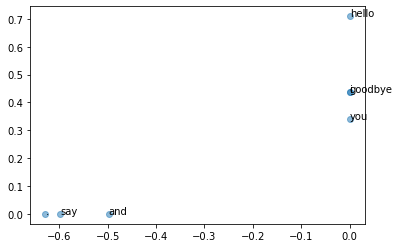

In [44]:
for word, word_id in test_word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)

# 本とは軸などが異なるが示してる部分は同等である
plt.show()

### PTBデータセット

- Penn TreeBank(PTB)コーパスの事
  - 元となるPTBの文章に対しいくつかの前処理が施されている
  
- PTBデータセットのダウンロードについては[deep-learning-from-scratch-2のリポジトリ](https://github.com/oreilly-japan/deep-learning-from-scratch-2)にある/dataset/ptb.pyを使用

In [45]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [46]:
window_size = 2
wordvec_size = 100
vocab_size = len(word_to_id)
print('counting co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence ...
calculating PPMI ...


e:\scripts\python\dl-from-scratch2\dl-from-scratch2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
e:\scripts\python\dl-from-scratch2\dl-from-scratch2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log2
  # This is added back by InteractiveShellApp.init_path()


1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done
100% done
calculating SVD ...

[query]you
 i: 0.687149703502655
 we: 0.6506008505821228
 'll: 0.5494743585586548
 some